In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat May 20 17:21:10 2023

@author: Anatoliy
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression

# Set the R environment variables
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.3.0"
os.environ["PATH"] = r"C:\Program Files\R\R-4.3.0\bin\x64" + ";" + os.environ["PATH"]

# Import required R packages and functions
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

# Import necessary R packages
r_utils = importr('utils')
r_splines = importr('splines')
r_smooth_spline = robjects.r['smooth.spline']

# Import necessary Python packages
from sklearn.metrics import r2_score

In [2]:
# Read the Bitcoin data from the specified CSV file
df = pd.read_csv('C:/Users/Anatoliy/Downloads/Bitcoin.csv')
df.sample(frac=.1).head()

,Date,Open,High,Low,Close,Adj Close,Volume
1295,2018-04-05,6848.649902,6933.819824,6644.799805,6811.470215,6811.470215,5639320064
753,2016-10-10,616.822021,621.317993,616.197021,618.994019,618.994019,67481104
1767,2019-07-21,10777.529297,10841.887695,10389.599609,10599.105469,10599.105469,17130580467
1403,2018-07-22,7417.799805,7537.950195,7383.819824,7418.490234,7418.490234,3695460096
2264,2020-11-29,17719.634766,18283.628906,17559.117188,18177.484375,18177.484375,31133957704


In [3]:
# Split the data into a training and test set using 80% as training data
df_train = df.sample(frac=0.8).rename(columns={'Date':'date', 'Close':'price'})[['date', 'price']]
df_test = df.drop(df_train.index).rename(columns={'Date':'date', 'Close':'price'})[['date', 'price']]
df_train.head()

,date,price
3044,2023-01-18,20688.781250
427,2015-11-19,326.148987
1282,2018-03-23,8879.620117
2503,2021-07-26,37337.535156
1645,2019-03-21,4029.326904


In [4]:
# Print the shape (rows and columns) of the training and test sets
print('Train датасет має {} рядків та {} колонок'.format(df_train.shape[0], df_train.shape[1]))
print('Test датасет має {} рядків та {} колонок'.format(df_test.shape[0], df_test.shape[1]))

Train датасет має 2502 рядків та 2 колонок
Test датасет має 626 рядків та 2 колонок


In [5]:
# Perform descriptive statistics on the training and test sets
df_train.describe()


,price
count,2502.000000
mean,13302.125066
std,16219.026432
min,199.259995
25%,703.657517
50%,7369.500000
75%,19197.232910
max,67566.828125


In [6]:
df_test.describe()

,price
count,626.000000
mean,12837.059500
std,15334.933114
min,178.102997
25%,792.106766
50%,7381.279785
75%,17806.524414
max,64949.960938


In [7]:
# Create a copy of the training data with non-null price values
df_train_2 = df_train[~df_train.price.isnull()].copy()

# Convert the 'date' column to datetime format
df_train_2.date = pd.to_datetime(df_train_2.date, format='%Y-%m-%d')

# Extract month information from the 'date' column
df_train_2['month'] = df_train_2.date.dt.month
df_train_2['month_name'] = df_train_2.date.dt.month_name()

# Extract weekday information from the 'date' column
df_train_2['weekday'] = df_train_2.date.dt.weekday
df_train_2['weekday_name'] = df_train_2.date.dt.day_name()

# Print the head of the modified training data
df_train_2.head()

,date,price,month,month_name,weekday,weekday_name
3044,2023-01-18,20688.781250,1,January,2,Wednesday
427,2015-11-19,326.148987,11,November,3,Thursday
1282,2018-03-23,8879.620117,3,March,4,Friday
2503,2021-07-26,37337.535156,7,July,0,Monday
1645,2019-03-21,4029.326904,3,March,3,Thursday


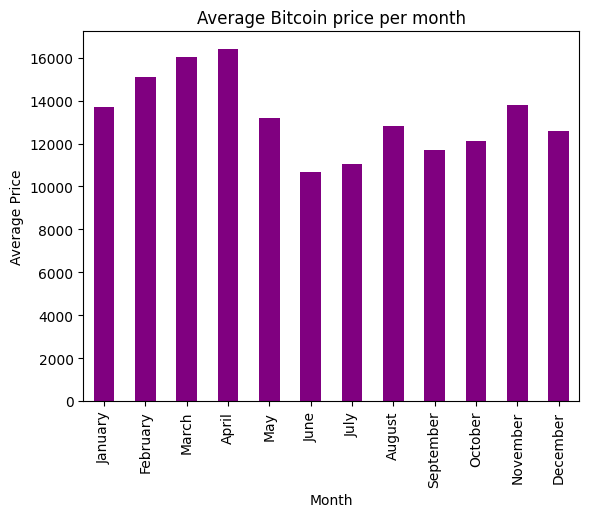

In [8]:
# Plot the average Bitcoin price per month
ax = df_train_2.groupby(['month', 'month_name']) \
    .agg({'price': np.mean}).reset_index() \
    .sort_values(by=['month']).plot.bar(x='month_name', y='price', color='purple', title='Average Bitcoin price per month')
ax.set_xlabel('Month')
ax.set_ylabel('Average Price')
ax.legend().set_visible(False)


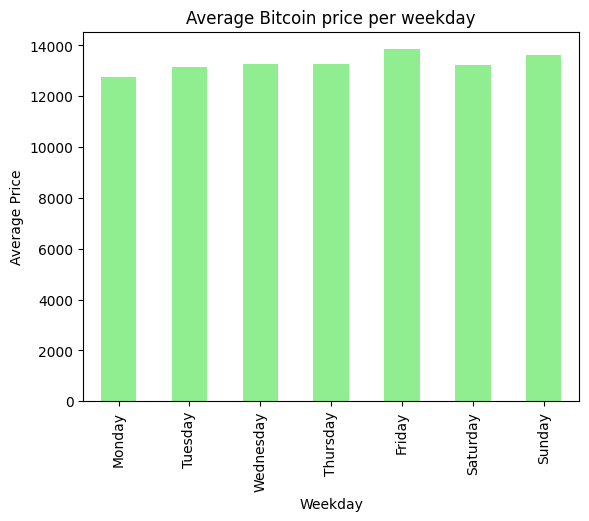

In [9]:
# Plot the average Bitcoin price per weekday
ax = df_train_2.groupby(['weekday', 'weekday_name']) \
    .agg({'price': np.mean}).reset_index() \
    .sort_values(by=['weekday']).plot.bar(x='weekday_name', y='price', color='lightgreen', title='Average Bitcoin price per weekday')
ax.set_xlabel('Weekday')
ax.set_ylabel('Average Price')
ax.legend().set_visible(False)



In [10]:
# Create a new DataFrame with the average price per day for the training data
df_train_summary = df_train_2.groupby(['date']) \
    .agg({'price': np.mean}).reset_index()

# Compute the minimum date in the training data
min_date = df_train_summary.date.min()

# Convert the 'date' column to represent days since the minimum date
df_train_summary.date = df_train_summary.date - min_date
df_train_summary.date = df_train_summary.date.dt.days
df_train_summary.sample(frac=.01)
df_train_summary.describe()

,date,price
count,2502.000000,2502.000000
mean,1558.240608,13302.125066
std,906.998741,16219.026432
min,0.000000,199.259995
25%,772.250000,703.657517
50%,1560.000000,7369.500000
75%,2347.500000,19197.232910
max,3126.000000,67566.828125


In [11]:
# Prepare the test data for analysis
df_test_2 = df_test[~df_test.price.isnull()].copy()
df_test_2.date = pd.to_datetime(df_test_2.date, format='%Y-%m-%d')
df_test_2['month'] = df_test_2.date.dt.month
df_test_2['month_name'] = df_test_2.date.dt.month_name()
df_test_2['weekday'] = df_test_2.date.dt.weekday
df_test_2['weekday_name'] = df_test_2.date.dt.day_name()

# Create a new DataFrame with the average price per day for the test data
df_test_summary = df_test_2.groupby(['date']) \
    .agg({'price': np.mean}).reset_index()

# Convert the 'date' column in the test data to represent days since the minimum date
df_test_summary.date = df_test_summary.date - min_date
df_test_summary.date = df_test_summary.date.dt.days
# Create a new DataFrame with the average price per day for the test data
df_test_summary = df_test_2.groupby(['date']) \
    .agg({'price': np.mean}).reset_index()

# Convert the 'date' column in the test data to represent days since the minimum date
df_test_summary.date = df_test_summary.date - min_date
df_test_summary.date = df_test_summary.date.dt.days

# Print a sample of the test data summary
df_test_summary.sample(frac=0.01)
df_test_summary.describe()

,date,price
count,626.000000,626.000000
mean,1579.523962,12837.059500
std,887.960583,15334.933114
min,-1.000000,178.102997
25%,827.000000,792.106766
50%,1588.500000,7381.279785
75%,2321.500000,17806.524414
max,3124.000000,64949.960938


In [12]:
# Access R's 'predict' and 'lm' functions
r_predict = robjects.r["predict"]
r_lm = robjects.r["lm"]

# Create an empty DataFrame to store R2 scores
df_r2_scores = pd.DataFrame({'R2': []})

R2 on training data:  0.5534321484631771
R2 on test data:  0.5507850492178414


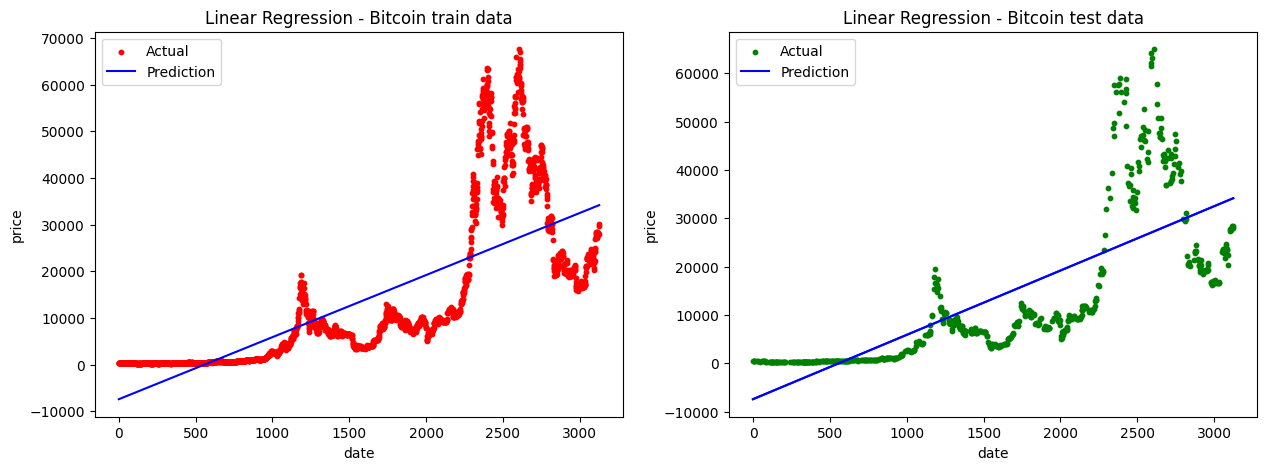

In [13]:
def fit_linear_regression(df_train_summary=df_train_summary, df_test_summary=df_test_summary, title='Linear Regression'):
    # Convert the pandas dataframes to R dataframes
    r_date_train = robjects.FloatVector(df_train_summary.date)
    r_price_train = robjects.FloatVector(df_train_summary.price)
    r_dataframe_train = robjects.DataFrame({'date': r_date_train, 'price': r_price_train})
    r_date_test = robjects.FloatVector(df_test_summary.date)
    r_price_test = robjects.FloatVector(df_test_summary.price)
    r_dataframe_test = robjects.DataFrame({'date': r_date_test, 'price': r_price_test})
    predict_df = robjects.DataFrame({'date': robjects.FloatVector(df_train_summary.date)})
    predict_test_df = robjects.DataFrame({'date': robjects.FloatVector(df_test_summary.date)})

    # Import the required R packages
    stats = importr('stats')

    # Fit the linear regression model using R's lm function
    lm_model = stats.lm("price ~ date", data=r_dataframe_train)

    # Generate predictions on training data
    train_predictions = robjects.r.predict(lm_model, newdata=r_dataframe_train)

    # Generate predictions on test data
    test_predictions = robjects.r.predict(lm_model, newdata=r_dataframe_test)

    # Convert the R vectors to numpy arrays
    train_predictions = np.array(train_predictions)
    test_predictions = np.array(test_predictions)

    # Calculate R-squared on training data
    train_r2 = robjects.r['summary'](lm_model).rx2('r.squared')[0]

    # Calculate R-squared on test data
    test_r2 = r2_score(df_test_summary['price'], test_predictions)
    # Create subplots for visualization
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Plotting the training data
    df_train_summary.plot.scatter(x='date', y='price', c='Red',title="{} - Bitcoin train data".format(title), ax=ax[0], s=10)
    ax[0].set_xlabel("date")
    ax[0].set_ylabel("price")
    ax[0].plot(predict_df.rx2("date"), train_predictions, c='Blue')
    
    # Print the R2 score on training data
    print("R2 on training data: ", train_r2)
    df_r2_scores.loc[title] = train_r2

    # Plotting the test data
    
    df_test_summary.plot.scatter(x='date', y='price', c='Green', title="{} - Bitcoin test data".format(title), ax=ax[1], s=10)
    plt.plot(df_test_summary['date'], test_predictions, c='Blue', label='Predicted')
    ax[1].set_xlabel("date")
    ax[1].set_ylabel("price")
    ax[1].plot(predict_test_df.rx2("date"), test_predictions, c='Blue', label='Prediction')
    # Add labels for the prediction lines
    ax[0].legend(['Actual', 'Prediction'])
    ax[1].legend(['Actual', 'Prediction'])
    # Print the R2 score on test data
    print("R2 on test data: ", test_r2)
    # Add the R2 score to the DataFrame
    df_r2_scores.loc[title] = test_r2
# Call the function with the provided dataframes df_train_summary and df_test_summary
fit_linear_regression(df_train_summary, df_test_summary)


22-order Polynomial
R2 on test: 0.921847973471223
44-order Polynomial
R2 on test: 0.9312422647780334
66-0rder Polynomial
R2 on test: 0.9380333081827431
88-0rder Polynomial
R2 on test: 0.9469603716408488


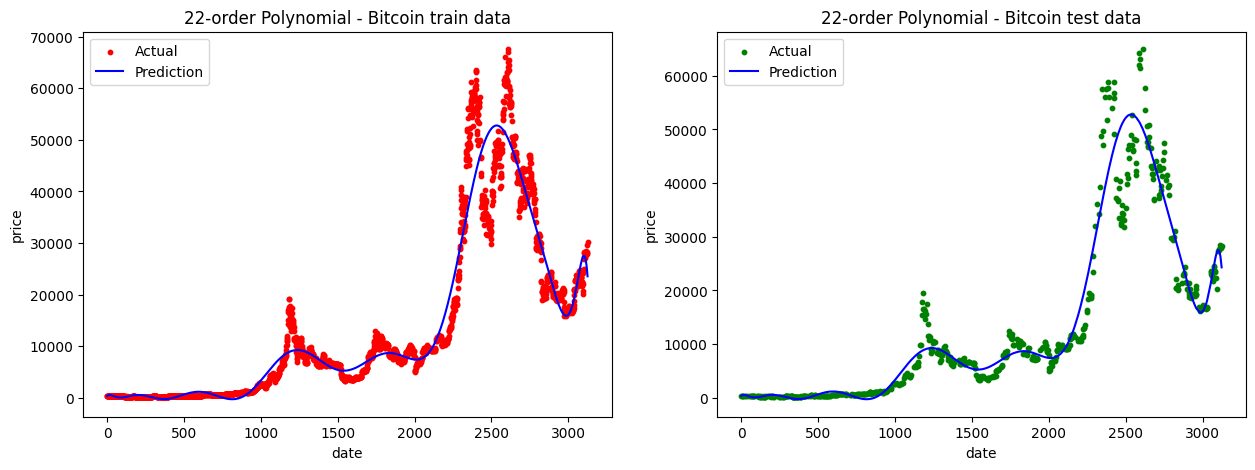

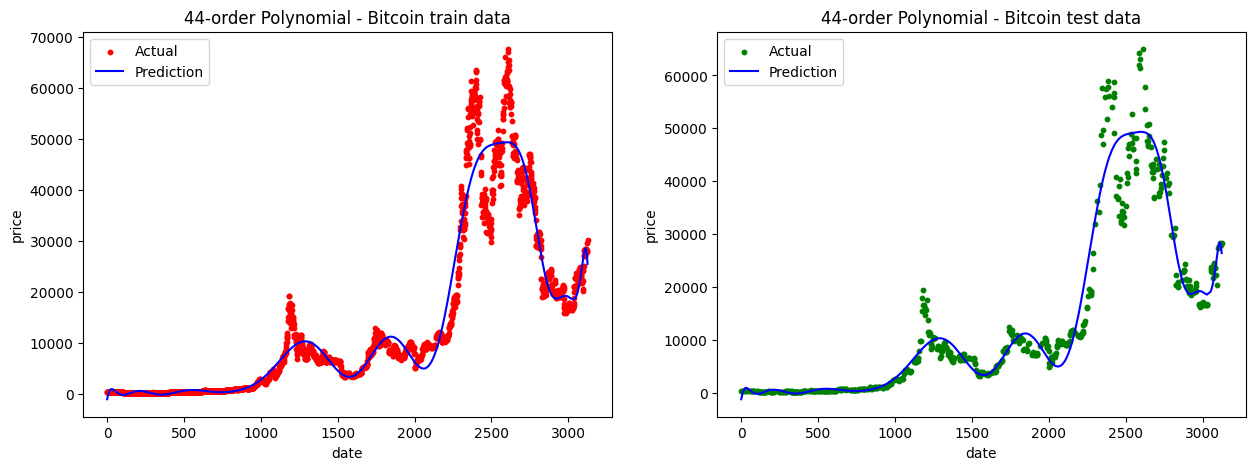

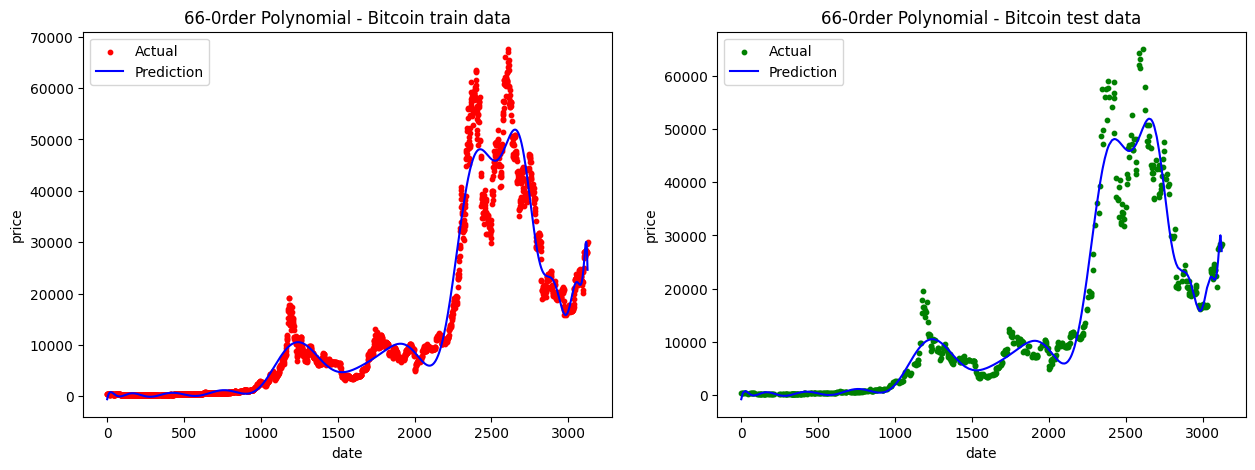

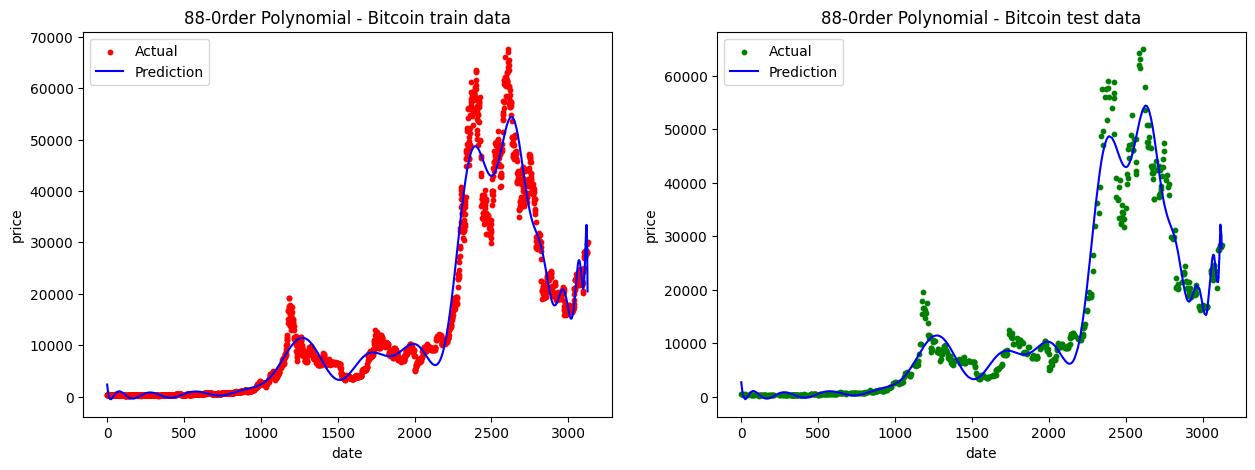

In [14]:
# Function that fits a polynomial model on the training dataset, plots the regression line, and reports the R2 score on the test set
def fit_polynomial(order, df_train_summary=df_train_summary, df_test_summary=df_test_summary, title='model'):
    r_date_train = robjects.FloatVector(df_train_summary.date)
    r_price_train = robjects.FloatVector(df_train_summary.price)
    crypto_train_r = robjects.DataFrame({'date': r_date_train, 'price': r_price_train})

    # Create the formula for the polynomial model using R's 'poly' function
    simple_formula = robjects.Formula("price ~ poly(date, {}, raw=TRUE)".format(order))

    # Fit the linear model using R's 'lm' function
    crypto_lm = r_lm(formula=simple_formula, data=crypto_train_r)

    # Create a DataFrame for prediction with the training dates
    predict_df = robjects.DataFrame({'date': robjects.FloatVector(df_train_summary.date)})

    # Make predictions using R's 'predict' function
    predictions = r_predict(crypto_lm, predict_df)

    # Create subplots for visualization
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Plot the training data points and the regression line
    df_train_summary.plot.scatter(x='date', y='price', c='Red', title="{} - Bitcoin train data".format(title), ax=ax[0], s=10, label='Actual')
    ax[0].set_xlabel("date")
    ax[0].set_ylabel("price")
    ax[0].plot(predict_df.rx2("date"), predictions, c='Blue', label='Prediction')

    # Create a DataFrame for prediction with the test dates
    predict_test_df = robjects.DataFrame({'date': robjects.FloatVector(df_test_summary.date)})

    # Make predictions on the test set using R's 'predict' function
    predictions_test = r_predict(crypto_lm, predict_test_df)

    # Plot the test data points and the regression line
    df_test_summary.plot.scatter(x='date', y='price', c='Green', title="{} - Bitcoin test data".format(title), ax=ax[1], s=10, label='Actual')
    ax[1].set_xlabel("date")
    ax[1].set_ylabel("price")
    ax[1].plot(predict_test_df.rx2("date"), predictions_test, c='Blue', label='Prediction')

    # Calculate the R2 score on the test set
    r2 = r2_score(df_test_summary.price, predictions_test)

    # Print the model title and the R2 score on the test set
    print(title)
    print("R2 on test: {}".format(r2))
    # Add labels for the prediction lines
    ax[0].legend(['Actual', 'Prediction'])
    ax[1].legend(['Actual', 'Prediction'])
    # Add the R2 score to the DataFrame
    df_r2_scores.loc[title] = r2
fit_polynomial(22, title='22-order Polynomial')
fit_polynomial(44, title='44-order Polynomial')
fit_polynomial(66, title='66-0rder Polynomial')
fit_polynomial(88, title='88-0rder Polynomial')

B-spline
R2 on test: 0.8971612833195418


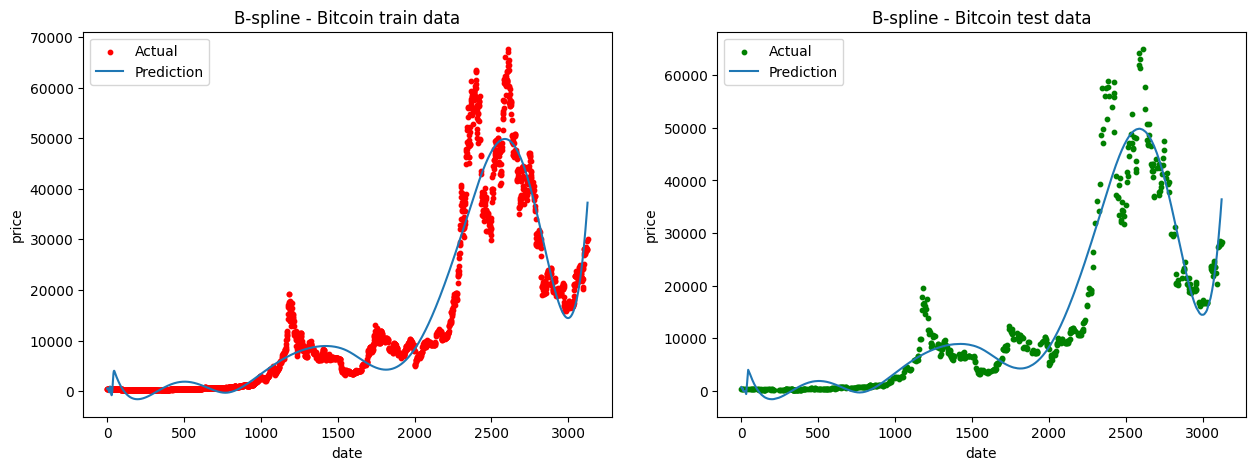

In [15]:
# function that fits a cubic B-spline on training dataset, plots the regression line and report the R2 on test
# The 'knots' parameter can be specified as a list of knots
def fit_b_spline(knots=np.quantile(df_train_summary.date,[.25,.50,.75]), df_train_summary=df_train_summary, df_test_summary=df_test_summary, title='B-spline'):
    # Convert train data to R vectors
    r_date_train = robjects.FloatVector(df_train_summary.date) 
    r_price_train = robjects.FloatVector(df_train_summary.price)

    # Convert knots to R vector
    r_quarts = robjects.FloatVector(knots)
    
    # Define the B-spline formula with knots and polynomial terms
    bs_formula = robjects.Formula("price ~ bs(date, knots=r_quarts) + bs(date**2, knots=r_quarts) + bs(date**3, knots=r_quarts)")
    bs_formula.environment['price'] = r_price_train
    bs_formula.environment['date'] = r_date_train
    bs_formula.environment['r_quarts'] = r_quarts

    # Fit the B-spline model
    bs_model = r_lm(bs_formula)
    
    # Prepare prediction data for training set
    predict_df = robjects.DataFrame({'date': robjects.FloatVector(df_train_summary.date)})
    
    # Generate predictions using the trained model
    bs_out = r_predict(bs_model, predict_df)

    # Plot the training set scatter plot and B-spline regression line
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    df_train_summary.plot.scatter(x='date',y='price',c='Red',title="{} - Bitcoin train data".format(title), ax=ax[0], s=10,)
    ax[0].set_xlabel("date")
    ax[0].set_ylabel("price");
    ax[0].plot(predict_df.rx2("date"),bs_out);
    
    # Prepare prediction data for test set
    predict_test_df = robjects.DataFrame({'date': robjects.FloatVector(df_test_summary.date)})
    
    # Generate predictions for the test set using the trained model
    bs_out_test = r_predict(bs_model, predict_test_df)
    
    # Plot the test set scatter plot and B-spline regression line
    df_test_summary.plot.scatter(x='date',y='price',c='Green',title="{} - Bitcoin test data".format(title), ax=ax[1], s=10)
    ax[1].set_xlabel("date")
    ax[1].set_ylabel("price");
    ax[1].plot(predict_test_df.rx2("date"),bs_out_test);
    # Add labels for the prediction lines
    ax[0].legend(['Actual', 'Prediction'])
    ax[1].legend(['Actual', 'Prediction'])
    # Calculate R-squared on the test set
    r2 = r2_score(df_test_summary.price, bs_out_test)
    print(title)    
    print("R2 on test: {}".format(r2))
    
    # Add R-squared value to the DataFrame
    df_r2_scores.loc[title] = r2
fit_b_spline()

Cubic B-spline, knots manually chosen
R2 on test: 0.9345904642361558


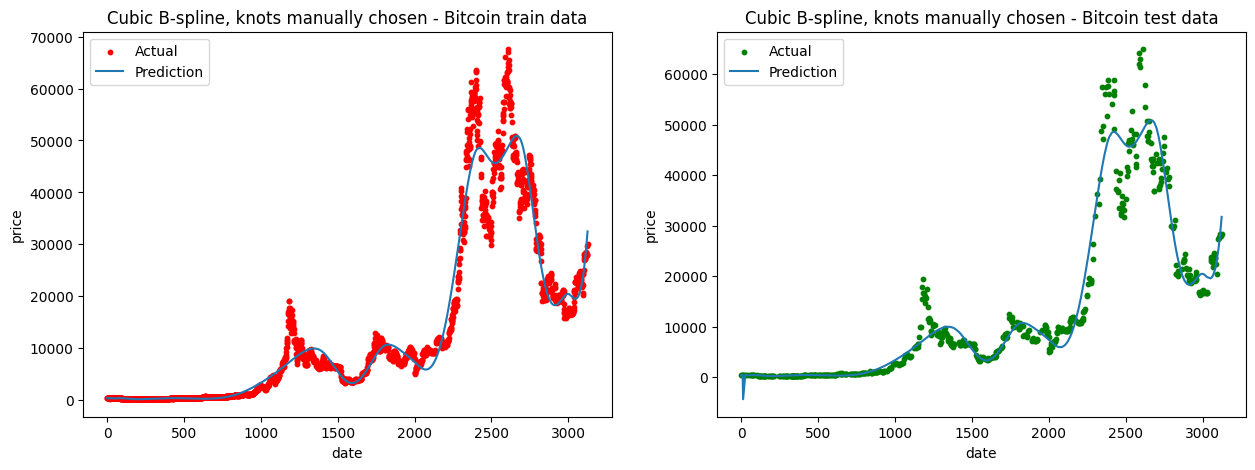

In [16]:
fit_b_spline(knots=[150,1000,1400,1600,1800,2000, 2400, 2500, 2700, 3000 ], title='Cubic B-spline, knots manually chosen')

n-spline - degree of freedom via cross-validation: 179
R2 on test: 0.7872911042486117


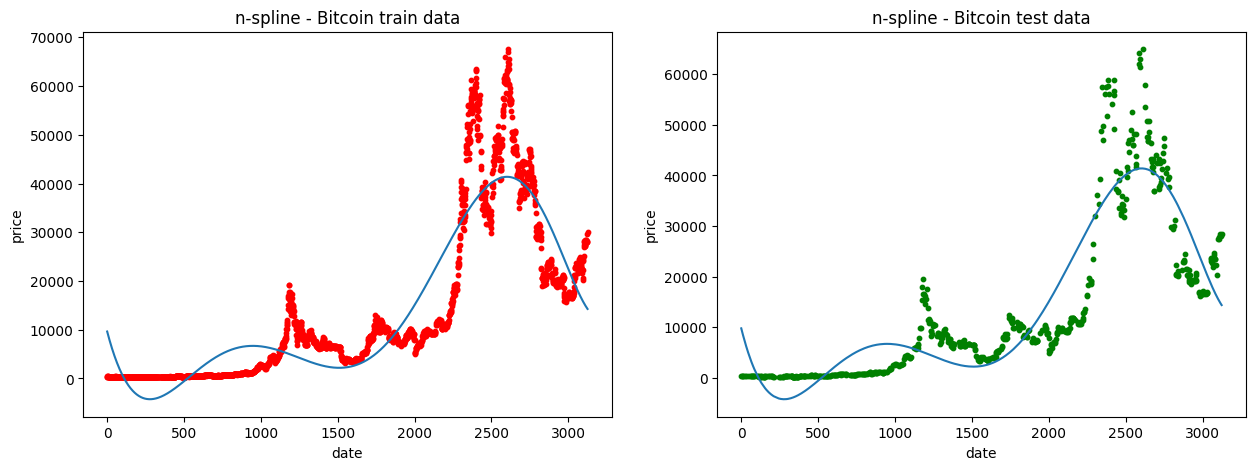

In [17]:
# function that fits a cubic Natural-spline on training dataset, plots the regression line and report the R2 on test
# the degree of freedom is calculated via CV
def fit_n_spline(df_train_summary=df_train_summary, df_test_summary=df_test_summary, title='n-spline'):
    # Convert train data to R vectors
    r_date_train = robjects.FloatVector(df_train_summary.date) 
    r_price_train = robjects.FloatVector(df_train_summary.price)
    
    # Perform cross-validated smoothing spline fit
    spline_cv = r_smooth_spline(x=r_date_train, y=r_price_train, cv=True, tol=1/100_000_000)    
    df_cv = int(spline_cv.rx2("df")[0])

    # Generate the natural spline design matrix
    ns_design = r_splines.ns(r_date_train, df=df_cv)
    
    # Define the natural spline formula with polynomial terms
    ns_formula = robjects.Formula("price ~ bs(date) + bs(date**2) + bs(date**3)")
    ns_formula.environment['price'] = r_price_train
    ns_formula.environment['date'] = r_date_train

    # Fit the natural spline model
    ns_model = r_lm(ns_formula)
    
    # Prepare prediction data for training set
    predict_df = robjects.DataFrame({'date': robjects.FloatVector(df_train_summary.date)})
    
    # Generate predictions using the trained model
    ns_out = r_predict(ns_model, predict_df)

    # Plot the training set scatter plot and natural spline regression line
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    df_train_summary.plot.scatter(x='date',y='price',c='Red',title="{} - Bitcoin train data".format(title), ax=ax[0], s=10)
    ax[0].set_xlabel("date")
    ax[0].set_ylabel("price");
    ax[0].plot(predict_df.rx2("date"),ns_out);
    
    # Prepare prediction data for test set
    predict_test_df = robjects.DataFrame({'date': robjects.FloatVector(df_test_summary.date)})
    
    # Generate predictions for the test set using the trained model
    ns_out_test = r_predict(ns_model, predict_test_df)
    
    # Plot the test set scatter plot and natural spline regression line
    df_test_summary.plot.scatter(x='date',y='price',c='Green',title="{} - Bitcoin test data".format(title), ax=ax[1], s=10)
    ax[1].set_xlabel("date")
    ax[1].set_ylabel("price");
    ax[1].plot(predict_test_df.rx2("date"),ns_out_test);
    
    # Calculate R-squared on the test set
    r2 = r2_score(df_test_summary.price, ns_out_test)
    print(title + " - degree of freedom via cross-validation: " + str(df_cv))
    print("R2 on test: {}".format(r2))
    
    # Add R-squared value to the DataFrame
    df_r2_scores.loc[title] = r2
fit_n_spline()

Smoothing spline - lambda found via cross-validation: 1.4662757817507642e-09
R2 on test: 0.9949724359380482


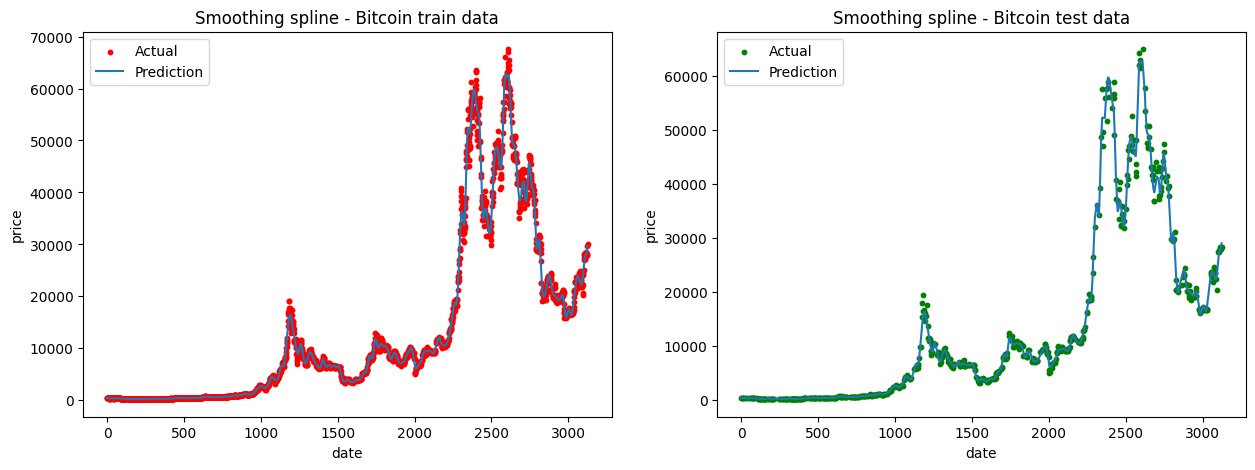

In [18]:
# function that fits a smoother spline on training dataset, plots the regression line and report the R2 on test
# the penalty lambda is calculated via CV
def fit_smoothing_spline(df_train_summary=df_train_summary, df_test_summary=df_test_summary, title='model'):
    # Convert train data to R vectors
    r_date_train = robjects.FloatVector(df_train_summary.date) 
    r_price_train = robjects.FloatVector(df_train_summary.price)
    
    # Perform cross-validated smoothing spline fit
    spline_cv = r_smooth_spline(x=r_date_train, y=r_price_train, cv=True, tol=1/1000000)    
    lambda_cv = spline_cv.rx2("lambda")[0]

    # Plot the training set scatter plot and smoothing spline fit
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    df_train_summary.plot.scatter(x='date',y='price',c='Red',title="{} - Bitcoin train data".format(title), ax=ax[0], s=10)
    ax[0].set_xlabel("date")
    ax[0].set_ylabel("price");
    ax[0].plot(spline_cv.rx2("x"),spline_cv.rx2("y"));
    
    # Prepare prediction data for the test set
    predict_test_df = robjects.DataFrame({'date': robjects.FloatVector(df_test_summary.date)})
    
    # Generate predictions using the smoothing spline fit
    predictions = r_predict(spline_cv, predict_test_df)
    
    # Plot the test set scatter plot and predicted values
    df_test_summary.plot.scatter(x='date',y='price',c='Green',title="{} - Bitcoin test data".format(title), ax=ax[1], s=10)
    ax[1].set_xlabel("date")
    ax[1].set_ylabel("price");
    ax[1].plot(df_test_summary.date,np.array(predictions.rx2("y")).ravel());
    
    # Calculate R-squared on the test set
    r2 = r2_score(df_test_summary.price, np.array(predictions.rx2("y")).ravel())
    print(title + " - lambda found via cross-validation: " + str(lambda_cv))
    print("R2 on test: {}".format(r2))
    # Add labels for the prediction lines
    ax[0].legend(['Actual', 'Prediction'])
    ax[1].legend(['Actual', 'Prediction'])
    # Add R-squared value to the DataFrame
    df_r2_scores.loc[title] = r2
    
    # Return the smoothing spline fit object
    return spline_cv
# Fit a smoothing spline on the training data and obtain the spline fit object
spline_cv = fit_smoothing_spline(title='Smoothing spline')



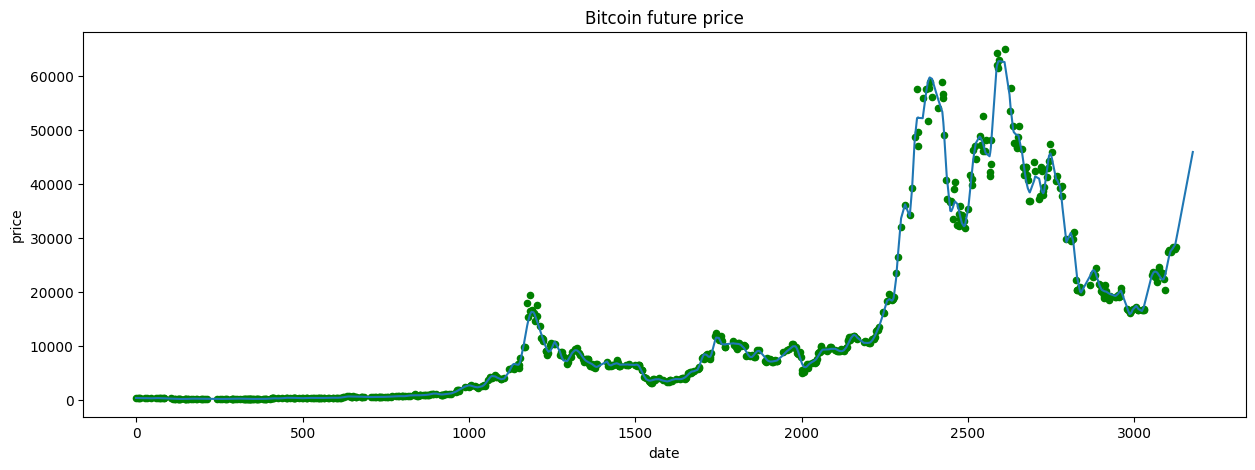

In [19]:

# Create a list of numbers ranging from 3129 to 3129+48 (exclusive)
lol = list(range(3129, 3129+48))

# Create a new variable called future_days by appending a new series to the 'date' column of df_test_summary
# The new series contains a range of numbers from 2860 to 2860+5 (exclusive)
future_days = pd.concat([df_test_summary.date, pd.Series(lol)], ignore_index=True)
def predict_smoothing_spline(model=spline_cv, future_days=future_days):
    # Create a figure and axis for plotting
    fig, ax = plt.subplots(1,1,figsize=(15,5))
    
    # Create a dataframe for predicting future prices using the specified 'future_days'
    predict_test_df = robjects.DataFrame({'date': robjects.FloatVector(future_days)})
    
    # Use the 'r_predict' function to make predictions using the given model and predict_test_df
    predictions = r_predict(model, predict_test_df)
    
    # Plot the scatter plot of the test data in green color
    df_test_summary.plot.scatter(x='date',y='price',c='Green',title="Bitcoin future price", ax=ax)
    
    # Set the x-axis label to 'date' and y-axis label to 'price'
    ax.set_xlabel("date")
    ax.set_ylabel("price");
    
    # Plot the predicted values for the future days
    ax.plot(future_days, np.array(predictions.rx2("y")).ravel())
predict_smoothing_spline()

In [20]:
df_r2_scores

,R2
Linear Regression,0.550785
22-order Polynomial,0.921848
44-order Polynomial,0.931242
66-0rder Polynomial,0.938033
88-0rder Polynomial,0.946960
B-spline,0.897161
"Cubic B-spline, knots manually chosen",0.934590
n-spline,0.787291
Smoothing spline,0.994972
